# 一个通用的机器学习项目结构

## 数据准备

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 512, 512])


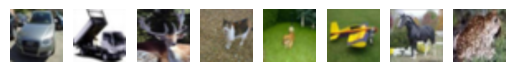

In [16]:

data_transform = transforms.Compose(
    [
        transforms.Resize(512),
        # transforms.RandomCrop((256,256)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# 对图像进行标准化
    ]
)
# # 数据集
# # 训练集 其中 0：明  1：清  2：民国
# full_dataset=ImageFolder(root="/root/autodl-tmp/data/", transform=data_transform)
# #85%的图片是训练集
# train_size = int(0.85 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
# print(len(train_dataset),len(test_dataset))
# train_loader = DataLoader(train_dataset, batch_size=mcfg.batch_size, shuffle=True, num_workers=12)
# test_loader = DataLoader(test_dataset, batch_size=mcfg.batch_size, shuffle=True, num_workers=12)
# return (train_loader, test_loader)

training_data = datasets.CIFAR10(
    root="data", train=True, download=True, transform=data_transform #transforms.ToTensor()
)
test_data = datasets.CIFAR10(
    root="data", train=False, download=True, transform=transforms.ToTensor()
)
train_loader = DataLoader(training_data, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True, num_workers=2)

tensor_image,train_labels=next(iter(train_loader))
# print(tensor_image)
fig, axes = plt.subplots(1, 8)
print(tensor_image[0].shape) #所以下一步需要把通道顺序调换一下

for i in range(8):
    img_np =tensor_image[i].permute(1, 2, 0).numpy()  # 将tensor的通道顺序从(C, H, W)转换为(H, W, C)
    axes[i].imshow(img_np)
    axes[i].axis('off')


## 模型搭建

In [19]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights
from collections import OrderedDict

In [20]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# resnet18 with pretrained weights
realmodel = models.resnet18(weights=ResNet18_Weights.DEFAULT)
classifier = nn.Sequential(
    #给每层设置一个名字，所以需要这种字典格式
    OrderedDict(
        [
            ("fc1", nn.Linear(512, 256)),
            ("relu", nn.ReLU()),
            ("fc2", nn.Linear(256, 10)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)

realmodel.fc = classifier
print(realmodel)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 训练

In [31]:
import torch
import torch.optim as optim
from torch.autograd import Variable

from pathlib import Path
import logging

logging.basicConfig(level=logging.INFO, filename='logs/test.log', filemode='w')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs=15
checkpoint_interval=10

logging.info(f"device: {device} \n epochs: {epochs} ")

In [27]:
def save_checkpoint(model: nn.Module, optimizer: torch.optim, path: str, epoch: int):
    p = Path(path)

    if not p.exists():
        p.mkdir()

    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    }

    checkpoint_name = "checkpoint_{}_epoch.pt".format(epoch)
    checkpoint_path = p / checkpoint_name
    torch.save(checkpoint, checkpoint_path)


In [28]:
def val(model: nn.Module, val_loader: DataLoader):
    model.to(device)
    model.eval()

    with torch.no_grad():
        running_acc = 0.0

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            equals = outputs.topk(1)[1].view(labels.shape) == labels
            running_acc += equals.sum().item()
        acc = running_acc / len(val_loader.dataset)

    return acc

In [32]:
optimizer = optim.SGD(realmodel.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()


realmodel.to(device)
for epoch in range(1):
    running_loss = 0.0
    realmodel.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = realmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        if i % 1000 == 999:
            running_loss = 0.0
    if epoch % checkpoint_interval == 0:
        save_checkpoint(
            model=realmodel, optimizer=optimizer, path="checkpoints", epoch=epoch
        )
    val_acc = val(realmodel, test_loader)
    print(f"epoch:{epoch},acc: {val_acc}")
    
save_checkpoint(model=realmodel, optimizer=optimizer, path="checkpoints",epoch=0)

KeyboardInterrupt: 

## 使用模型

In [34]:
p = Path("checkpoints")
model_name = "checkpoint_1_epoch.pkl"
model_path = p / model_name

model_load=torch.load(model_path)
realmodel.load_state_dict(model_load['model_state_dict'])


<All keys matched successfully>

torch.Size([3, 32, 32])
real label: 
tensor([3, 6, 7, 1, 7, 5, 4, 7])
predict label: 
tensor([3, 6, 7, 1, 7, 5, 4, 5])


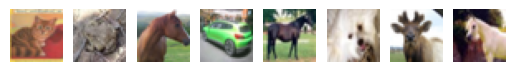

In [41]:
tensor_image,test_labels=next(iter(test_loader))
# print(tensor_image)
fig, axes = plt.subplots(1, 8)
print(tensor_image[0].shape) #所以下一步需要把通道顺序调换一下
print("real label: ")
print(test_labels)

for i in range(8):
    img_np =tensor_image[i].permute(1, 2, 0).numpy()  # 将tensor的通道顺序从(C, H, W)转换为(H, W, C)
    axes[i].imshow(img_np)
    axes[i].axis('off')

# for i in range(8):
label=realmodel(tensor_image)
print("predict label: ")
print(label.topk(1)[1].view(labels.shape))

# 评估模型好坏的方法